ret2 160.0


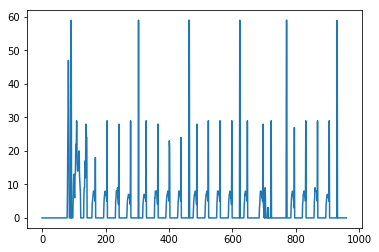

(array([ 83,  92, 304, 463, 464, 623, 770, 771, 930], dtype=int64),)
[[  9 212 159   1 159 147   1 159]]
[  1   9 212 159   1 159 147   1 159]
measures [ 92 304 463 623 770 930]


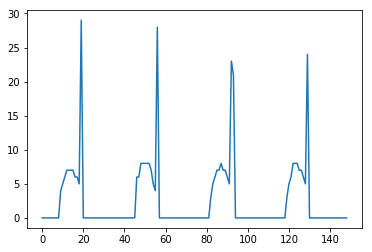

Seg Count Res
[ 0.  0.  0.  0.  0.  0.  0.  4.  9. 15. 22. 29. 32. 34. 34. 33. 31. 53.
 46. 40. 34. 29.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  6. 12. 20. 28. 36. 38. 40. 39. 36. 32.
 52. 44. 37. 32. 28.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  3.  8. 14. 21. 28. 33. 35. 36. 35. 33.
 48. 62. 55. 49. 44. 21.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  3.  8. 14. 22. 30. 35. 37. 38. 36.
 33. 49. 42. 35. 29. 24.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


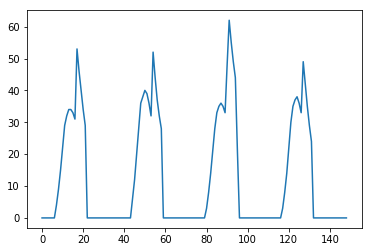

149


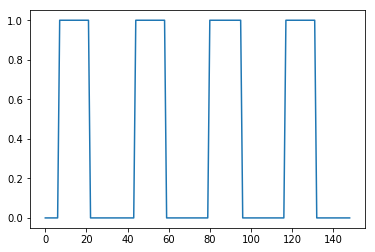

done
done
done
done


In [47]:
import cv2
import numpy as np

img = cv2.imread('ode_to_joy.jpg',0)
height, width = img.shape[:2]

"""Resizing image"""
img_res = cv2.resize(img,(int(0.5*width), int(0.5*height)))#, interpolation = cv.INTER_CUBIC)


#cv2.imshow('img_resize', img_res)
"""Otsu Binarisation"""
ret2,th2 = cv2.threshold(img_res,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('ret2', ret2)
#cv2.imshow('thresh', th2)

"""Canny Edge Detection"""
edges = cv2.Canny(th2,50,150,apertureSize = 3)

"""Erosion - to get only the horizontal lines
    Subtract erosion from edges to remove the staff lines"""
kernel = np.ones((1,5), np.uint8)

erosion = cv2.erode(edges, kernel, iterations = 1)
erosion_copy = erosion

#cv2.imshow('erosion', erosion)

result = cv2.subtract(edges, erosion)
#cv2.imshow('result', result)

"""To find the y-values of staff lines"""
sum_rows = np.sum(erosion, axis=1)
max_sum = np.amax(sum_rows)

ind = np.where(sum_rows > 0.7 * max_sum)
new_ind = ind[0][::2] + 1  ## contains y-values of staff lines

ref_ind = new_ind[::5] ## Reference value for each set of 5 staff lines
ref_ind2 = new_ind[4::5]
bw = cv2.bitwise_not(th2)
horizontal = bw.copy()
vertical = bw.copy()
cv2.waitKey(0)
cv2.destroyAllWindows()

    #Staff line thickness
from collections import Counter
ind = ind[0][:]
a = [x - ind[i-1] for i,x in enumerate(ind)][1:]
data = Counter(a)
b = data.most_common(1)
slt = b[0][0] #slt is staff line thickness
    #slt

    #Removing the horizontal lines
kernel_v = np.ones((2*slt,1),dtype = np.uint8)
bw_erode1 = cv2.erode(vertical,kernel_v,iterations = 1)
bw_dilate1 = cv2.dilate(bw_erode1,kernel_v,iterations = 1)
#cv2.imshow('bw_dilate',bw_dilate1)
 

vertical_not = cv2.bitwise_not(bw_dilate1) #vertical
#cv2.imshow('not',vertical_not)
#cv2.imshow('bw_dilate',bw_dilate1)
smooth = vertical_not.copy()
blur1 = cv2.filter2D(smooth,-1,(np.ones((2,1),np.float32)/2))
#cv2.imwrite('C:/Users/Sahith/Desktop/IEEE Sheet Vision/staff_removal.jpg',blur1)
#cv2.imshow('a',blur1)
#cv2.waitKey(0)
#cv2.destroyAllWindows()    

final_image = ~blur1
#cv2.imshow('b',blur2)
#cv2.waitKey(0)
#cv2.destroyAllWindows() 
######################################
########### New code : ##############
####################################

# Projecting on y
count = np.zeros(960)

for i in range(55,125):
    for j in range(960):
        #if(result2[i][j]==255):
        if(blur1[i][j]==0):
            count[j]=count[j]+1

#cv2.imshow('result2', result2)

"""count2 = np.zeros(225-125) 

for i in range(125,225):
    for j in range(624,659):
        if(result2[i][j]==0):
            count2[i-125] = count2[i-125] + 1"""


########################################
plt.plot(count)
plt.show()

measures1 = np.where(count>40)
print(measures1)
meas_diff1 = np.diff(measures1)
print(meas_diff1)
meas_diff = np.insert(meas_diff1[0], 0, 1) 
print(meas_diff)

measures = np.delete(measures1, np.where(meas_diff < width/300))
print('measures',measures)

origin_measure = measures[1]+5
#CHANGE THESE values based on staff lines positions
seg_y_top = 40 
seg_y_bottom = 130
###########
img_seg_meas = final_image[seg_y_top:seg_y_bottom, measures[1]+5:measures[2]-5]
cv2.imshow('segmented',img_seg_meas)


# Hardcoded now for the origin, CHANGE LATER!!!!!!

# Extract the individual components in each measure
#print('notespos',note_pos)

height_seg,width_seg = np.shape(img_seg_meas)
seg_count = np.zeros(width_seg)
for i in range(height_seg):
    for j in range(width_seg):
        #if(result2[i][j]==255):
        if(img_seg_meas[i][j]==255):
            seg_count[j]=seg_count[j]+1

plt.plot(seg_count)
plt.show()

#smoothen a little

seg_count_result = np.convolve(seg_count,np.ones(5),mode = 'same')

print("Seg Count Res")
print(seg_count_result)
plt.plot(seg_count_result)
plt.show()

#set threshold to find gaps
seg_count_positions = np.zeros(width_seg)
print(width_seg)
for i in range(width_seg):
    if(seg_count_result[i]>0):  #give 3 as threshold
        seg_count_positions[i] = 1
        
plt.plot(seg_count_positions)
plt.show()

start_end_pos = np.where(np.abs(np.diff(seg_count_positions))>0)

seg_positions_final = origin_measure + start_end_pos

for i1 in np.arange(0,len(seg_positions_final[0]), 2):
    img_seg = final_image[seg_y_top:seg_y_bottom, seg_positions_final[0][i1]:seg_positions_final[0][i1+1]]
    print('done')
    cv2.imshow('seg',img_seg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    

seg1 = np.where((count>5) & (count<40))
#print(seg1)

#plt.plot(seg1)
#plt.show()

seg_diff = np.diff(seg1)
#print(seg_diff)

seg_mean = np.mean(seg_diff)
#print(seg_mean)

ref_ind = new_ind[::5] ## Reference value for each set of 5 staff lines
ref_ind2 = new_ind[4::5]

spacing = (ref_ind2 - ref_ind)/4 ## Spacing bw 2 staff lines
""""""

#cv2.imwrite('erosion.jpg', erosion)
#cv2.imwrite('edges.jpg', edges)
#cv2.imwrite('result.jpg', result)

min_line_len = 100
max_line_gap = 20

cv2.waitKey(0)
cv2.destroyAllWindows()

In [33]:
print(len(erosion))

540


width 1920
ret2 160.0


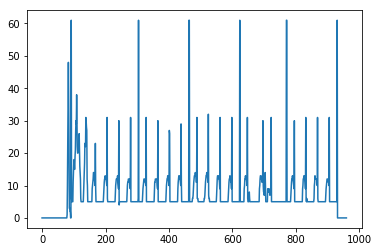

(array([ 83,  92, 304, 463, 464, 623, 770, 771, 930], dtype=int64),)
[[  9 212 159   1 159 147   1 159]]
[  1   9 212 159   1 159 147   1 159]
measures [ 92 304 463 623 770 930]


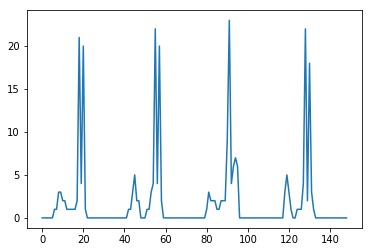

Seg Count Res
[ 0.  0.  0.  0.  1.  2.  5.  8. 10. 11. 11.  9.  7.  6.  5.  6. 26. 29.
 48. 48. 46. 25. 21.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  1.  2.  5. 10. 12. 13. 12.  9.  4.  3.  2.  5.  9. 31.
 34. 53. 52. 48. 26. 22.  2.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  1.  4.  6.  8. 10. 10.  8.  8.  8.  8. 16. 38.
 40. 44. 49. 46. 23. 19. 13.  6.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  3.  8. 11. 12. 12.  9.  5.  3.  3.  7.
 29. 30. 47. 49. 46. 24. 22.  4.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.]


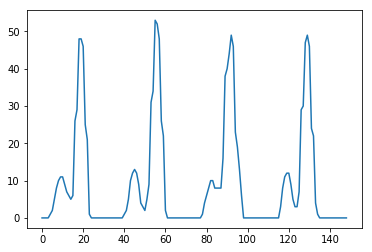

149


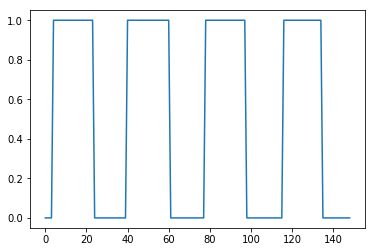

(array([ 80,  81,  82,  84,  85,  93,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 158, 159, 160, 161, 162, 163, 164, 165,
       166, 167, 168, 169, 194, 195, 196, 197, 198, 199, 200, 201, 202,
       203, 204, 205, 206, 231, 232, 233, 234, 235, 236, 237, 238, 239,
       240, 241, 242, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 303, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326,
       327, 328, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402,
       428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 474,
       475, 476, 477, 478, 479, 480, 481, 482, 483, 484, 485, 486, 487,
       488, 489, 490, 491, 511, 512, 513, 514, 515, 516, 517, 518, 519,
       520, 521, 522, 523, 524, 525, 526, 527, 550, 551, 552, 5

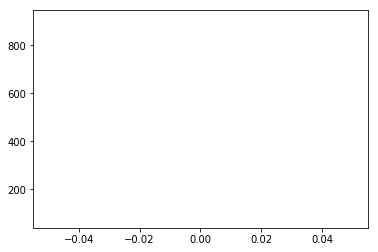

[[ 1  1  2  1  8  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  9  1  1  1  1  1  1  1  1  1  1  1  1 15  1  1  1  1
   1  1  1  1  1  1  1 25  1  1  1  1  1  1  1  1  1  1  1  1 25  1  1  1
   1  1  1  1  1  1  1  1 26  1  1  1  1  1  1  1  1  1  1  1 24 14  1  1
   1  1  1  1  1  1  1  1  1 26  1  1  1  1  1  1  1  1  1  1  1 26  1  1
   1  1  1  1  1  1  1  1  1 26  1  1  1  1  1  1  1  1  1  1  1 35  1  1
   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 20  1  1  1  1  1  1  1  1
   1  1  1  1  1  1  1  1 23  1  1  1  1  1  1  1  1  1  1  1 26  1  1  1
   1  1  1  1  1  1  1  1 26 13  1  1  1  1  1  1  1  1  1  1  1  4  1  1
  31  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  7  1  1  1
   1  1  1  1  1  1  1  1 62  1  1  1  1  1  1  1  1  1  1  1 26  1  1  1
   1  1  1  1  1  1  1  1  2 23  1  1  1  1  1  1  1  1  1  1  1  1 25  1
   1  1  1  1  1  1  1  1  1  1]]
2.7684563758389262


In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('ode_to_joy.jpg',0)
height, width = img.shape[:2]
print('width', width)

"""Resizing image"""
img_res = cv2.resize(img,(int(0.5*width), int(0.5*height)))#, interpolation = cv.INTER_CUBIC)


#cv2.imshow('img_resize', img_res)
"""Otsu Binarisation"""
ret2,th2 = cv2.threshold(img_res,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
print('ret2', ret2)
#cv2.imshow('thresh', th2)

"""Canny Edge Detection"""
edges = cv2.Canny(th2,50,150,apertureSize = 3)

"""Erosion - to get only the horizontal lines
    Subtract erosion from edges to remove the staff lines"""
kernel = np.ones((1,5), np.uint8)

erosion = cv2.erode(edges, kernel, iterations = 1)
erosion_copy = erosion

#cv2.imshow('erosion', erosion)

result = cv2.subtract(edges, erosion)
#cv2.imshow('result', result)

"""To find the y-values of staff lines"""
sum_rows = np.sum(erosion, axis=1)
max_sum = np.amax(sum_rows)

ind = np.where(sum_rows > 0.7 * max_sum)
new_ind = ind[0][::2] + 1  ## contains y-values of staff lines

####trying out some stuff

"""for i in ind[0]:
    erosion[i,:] = 255

#cv2.imshow('erosion2', erosion)

result2 = cv2.add(result , erosion_copy)
result2 = cv2.subtract(result2, erosion)


kernel2 = np.ones((2,2), np.uint8)
result2 = cv2.dilate(result2,kernel2,iterations = 1)
"""
# Projecting on y
count = np.zeros(960)

for i in range(55,125):
    for j in range(960):
        #if(result2[i][j]==255):
        if(th2[i][j]==0):
            count[j]=count[j]+1

#cv2.imshow('result2', result2)

"""count2 = np.zeros(225-125) 

for i in range(125,225):
    for j in range(624,659):
        if(result2[i][j]==0):
            count2[i-125] = count2[i-125] + 1"""


########################################
plt.plot(count)
plt.show()

measures1 = np.where(count>40)
print(measures1)
meas_diff1 = np.diff(measures1)
print(meas_diff1)
meas_diff = np.insert(meas_diff1[0], 0, 1) 
print(meas_diff)

measures = np.delete(measures1, np.where(meas_diff < width/300))
print('measures',measures)

origin_measure = measures[1]+5
#CHANGE THESE values based on staff lines positions
seg_y_top = 40 
seg_y_bottom = 130
###########
img_seg_meas = result[seg_y_top:seg_y_bottom, measures[1]+5:measures[2]-5]
cv2.imshow('segmented',img_seg_meas)


# Hardcoded now for the origin, CHANGE LATER!!!!!!

# Extract the individual components in each measure
#print('notespos',note_pos)

height_seg,width_seg = np.shape(img_seg_meas)
seg_count = np.zeros(width_seg)
for i in range(height_seg):
    for j in range(width_seg):
        #if(result2[i][j]==255):
        if(img_seg_meas[i][j]==255):
            seg_count[j]=seg_count[j]+1

plt.plot(seg_count)
plt.show()

#smoothen a little

seg_count_result = np.convolve(seg_count,np.ones(5),mode = 'same')

print("Seg Count Res")
print(seg_count_result)
plt.plot(seg_count_result)
plt.show()

#set threshold to find gaps
seg_count_positions = np.zeros(width_seg)
print(width_seg)
for i in range(width_seg):
    if(seg_count_result[i]>0):  #give 3 as threshold
        seg_count_positions[i] = 1
        
plt.plot(seg_count_positions)
plt.show()

start_end_pos = np.where(np.abs(np.diff(seg_count_positions))>0)

seg_positions_final = origin_measure + start_end_pos

for i1 in np.arange(0,len(seg_positions_final[0]), 2):
    img_seg = final_image[seg_y_top:seg_y_bottom, seg_positions_final[0][i1]:seg_positions_final[0][i1+1]]
    cv2.imshow('seg',img_seg)
    

seg1 = np.where((count>5) & (count<40))
print(seg1)

plt.plot(seg1)
plt.show()

seg_diff = np.diff(seg1)
print(seg_diff)

seg_mean = np.mean(seg_diff)
print(seg_mean)

ref_ind = new_ind[::5] ## Reference value for each set of 5 staff lines
ref_ind2 = new_ind[4::5]

spacing = (ref_ind2 - ref_ind)/4 ## Spacing bw 2 staff lines
""""""

#cv2.imwrite('erosion.jpg', erosion)
#cv2.imwrite('edges.jpg', edges)
#cv2.imwrite('result.jpg', result)

min_line_len = 100
max_line_gap = 20

cv2.waitKey(0)
cv2.destroyAllWindows()

In [6]:
print(measures)

[ 92 304 463 623 770 930]


In [37]:
np.shape(final_image)

(540, 960)

In [42]:
len(seg_positions_final[0])



8

In [16]:
seg_positions_final

array([[312, 332, 348, 369, 386, 406, 424, 443]], dtype=int64)

In [18]:
new_ind


array([ 64,  72,  80,  89,  97, 157, 165, 173, 182, 190, 352, 361, 369,
       377, 386, 446, 454, 462, 471, 479], dtype=int64)

In [35]:
np.arange(0,5,2)

array([0, 2, 4])